In [1]:
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from keras.applications import ResNet50
from keras.applications.resnet import preprocess_input

from keras_preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers

from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard

In [2]:
train = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.05,       
        shear_range=0.05,
        validation_split=0.25,
        horizontal_flip=True,
        fill_mode="nearest")
validation =ImageDataGenerator(
        rotation_range=20,
        validation_split=0.25)

In [3]:
train_dir = pd.read_csv('Dataset/First50/Lables.csv')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = train.flow_from_dataframe(train_dir, directory=None,
                                          x_col='Path',
                                          y_col='Total Score',
                                          weight_col=None,
                                          validate_filenames=True,
                                          subset="training",
                                          shuffle=True,
                                          batch_size=BATCH_SIZE,
                                          target_size=IMG_SIZE)


validation_dataset = validation.flow_from_dataframe(train_dir, directory=None,
                                          x_col='Path',
                                          y_col='Total Score',
                                          weight_col=None,
                                          validate_filenames=True,
                                          subset="validation",
                                          shuffle=True,
                                          batch_size=BATCH_SIZE,
                                          target_size=IMG_SIZE)




Found 38 validated image filenames belonging to 10 classes.
Found 12 validated image filenames belonging to 10 classes.


In [4]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input


In [7]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=(160,160,3),
                                               include_top=False,
                                               weights=None)

In [8]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(6, 5, 5, 2048)


In [9]:
base_model.trainable = False

In [10]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(6, 2048)


In [11]:
prediction_layer = tf.keras.layers.Dense(10,activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(6, 10)


In [12]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x =inputs
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [18]:

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [19]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

1/1 [==============================] - 2s 2s/step - loss: 2.9899 - accuracy: 0.1667


In [20]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.99
initial accuracy: 0.17


In [21]:
history = model.fit(train_dataset,
                    epochs=80,
                    validation_data=validation_dataset)

Epoch 1/80
2/2 [==============================] - 4s 389ms/step - loss: 6.2269 - accuracy: 0.1316 - val_loss: 6.4707 - val_accuracy: 0.0833
Epoch 2/80
2/2 [==============================] - 0s 346ms/step - loss: 5.8060 - accuracy: 0.1579 - val_loss: 5.6406 - val_accuracy: 0.0833
Epoch 3/80
2/2 [==============================] - 0s 345ms/step - loss: 5.3469 - accuracy: 0.1053 - val_loss: 5.1807 - val_accuracy: 0.1667
Epoch 4/80
2/2 [==============================] - 0s 356ms/step - loss: 4.3061 - accuracy: 0.2105 - val_loss: 4.7364 - val_accuracy: 0.1667
Epoch 5/80
2/2 [==============================] - 0s 163ms/step - loss: 5.0335 - accuracy: 0.1053 - val_loss: 5.6453 - val_accuracy: 0.1667
Epoch 6/80
2/2 [==============================] - 0s 169ms/step - loss: 4.0155 - accuracy: 0.2105 - val_loss: 6.0402 - val_accuracy: 0.0833
Epoch 7/80
2/2 [==============================] - 0s 339ms/step - loss: 4.1300 - accuracy: 0.0789 - val_loss: 6.6262 - val_accuracy: 0.0833
Epoch 8/80
2/2 [====

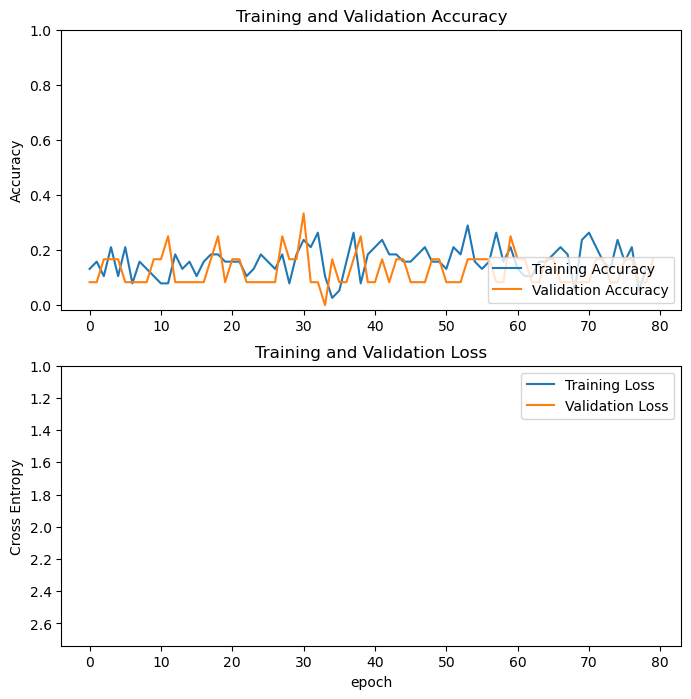

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()